# **Data and Information Quality project: Accuracy analysis**

# Import google drive and libraries

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/DIQ/project

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/DIQ/project


In [6]:
!pip install ydata_profiling sweetviz lux-api autoviz plotly matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.6/357.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.0/127.0 kB 14.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.1 MB/s eta 0:00:00
  Prepar

In [ ]:
from ydata_profiling import ProfileReport

In [2]:
!pip install outlier-utils

In [3]:
!git clone https://github.com/camillasancricca/DATADIQ.git

fatal: destination path 'DATADIQ' already exists and is not an empty directory.


In [4]:
import pandas as pd
import numpy as np
import random

from projects.A_data_collection import make_dataset_for_classification
from projects.D_data_analysis import classification
from projects.E_plot_results import plot

In [5]:
import seaborn as sns
from numpy import quantile

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt

from DATADIQ import scripts_for_E5 as s

# Dataset and parameters

In [6]:
X, y = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

In [7]:
X = pd.DataFrame(X)

In [10]:
X.shape

(1000, 5)

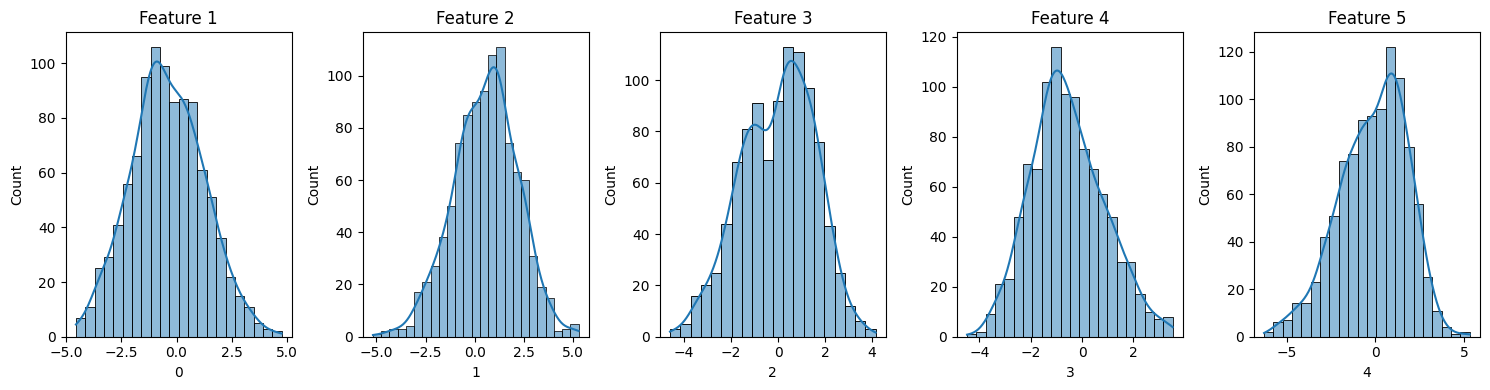

In [9]:
# Plot a time series for each category
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

axes = axes.flatten()

sns.histplot(X[0], kde=True, ax=axes[0])
axes[0].set_title('Feature 1')
sns.histplot(X[1], kde=True, ax=axes[1])
axes[1].set_title('Feature 2')
sns.histplot(X[2], kde=True, ax=axes[2])
axes[2].set_title('Feature 3')
sns.histplot(X[3], kde=True, ax=axes[3])
axes[3].set_title('Feature 4')
sns.histplot(X[4], kde=True, ax=axes[4])
axes[4].set_title('Feature 5')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [11]:
X.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
dtype: object

In [12]:
X.describe()

,0,1,2,3,4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.412924,0.553137,-0.011211,-0.558847,-0.113063
std,1.645251,1.632377,1.561119,1.418718,1.900478
min,-4.547693,-5.177543,-4.606016,-4.486288,-6.269763
25%,-1.492642,-0.518644,-1.157154,-1.514788,-1.410745
50%,-0.502763,0.655087,0.166307,-0.688277,0.077678
75%,0.708740,1.615910,1.134561,0.343309,1.286961
max,4.750400,5.291507,4.161042,3.534872,5.326312


In [ ]:
PROFILE = ProfileReport(X, title="Pandas Profiling Report")
PROFILE

In [8]:
# LIST OF ALGORITHMS FOR CLASSIFICATION
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]

In [9]:
SEED = 2023

# Main code

## Data pollution

In [10]:
np.random.seed(seed=SEED)

In [11]:
# this function generates random numbers based on a gaussian centered on mean and variance depending on the situation
def generate_sample(dataframe, column=0, mean=.1, variance=0):
  selector = np.random.randint(2)
  if selector == 0:
    min_value = dataframe.min()[column]
    return np.random.normal(min_value - abs(min_value * mean), variance)
  else:
    max_value = dataframe.max()[column]
    return np.random.normal(max_value + abs(max_value * mean), variance)

In [12]:
# this function generates an array of 1000 elements (zeros and ones) randomly ordered
def generate_mask(percentage):
  num_ones = int(1000*percentage)
  num_zeros = 1000 - num_ones

  ones = np.ones(num_ones)
  zeros = np.zeros(num_zeros)
  mask = np.concatenate((ones, zeros))
  np.random.RandomState(SEED).shuffle(mask)

  return mask

In [13]:
# this function pollutes the dataset to lower the accuracy dimension
# random samples or each row are drawn and substituted with random values previously generated
# parameters:
# X: dataset to be polluted
# percentage: amount of rows that are affected by the pollution function
# distance: mean of new random sample (how shifted the new samples are from the actual distribution)
# variance: variance of the random sample
#
# return: polluted dataset
def pollute_accuracy(X, percentage=.05, mean=2, variance=0):
  polluted_x = X.copy()
  mask = generate_mask(percentage)

  for i in range(1000):
    if mask[i] == 1:
      selector = np.random.randint(5)
      # pollute one column of a row
      polluted_x.at[i, selector] = generate_sample(X, 0, mean, variance)

      # pollute all columns of a row
      '''new_row = {0: generate_sample(X, 0, distance, variance),
               1: generate_sample(X, 1, distance, variance),
               2: generate_sample(X, 2, distance, variance),
               3: generate_sample(X, 3, distance, variance),
               4: generate_sample(X, 4, distance, variance)}
      polluted_x.iloc[i] = new_row'''

  return polluted_x

In [14]:
# generate experiment datasets with varying parameters
datasets = []
datasets.append(pollute_accuracy(X, percentage=.05, mean=2, variance=0))  # experiment 0
datasets.append(pollute_accuracy(X, percentage=.1,  mean=2, variance=2))  # experiment 1
datasets.append(pollute_accuracy(X, percentage=.15, mean=3, variance=0))  # experiment 2
datasets.append(pollute_accuracy(X, percentage=.2,  mean=3, variance=2))  # experiment 3
datasets.append(pollute_accuracy(X, percentage=.25, mean=4, variance=0))  # experiment 4
datasets.append(pollute_accuracy(X, percentage=.3,  mean=4, variance=2))  # experiment 5
datasets.append(pollute_accuracy(X, percentage=.35, mean=5, variance=0))  # experiment 6
datasets.append(pollute_accuracy(X, percentage=.4,  mean=5, variance=2))  # experiment 7
datasets.append(pollute_accuracy(X, percentage=.45, mean=6, variance=0))  # experiment 8
datasets.append(pollute_accuracy(X, percentage=.5,  mean=6, variance=2))  # experiment 9

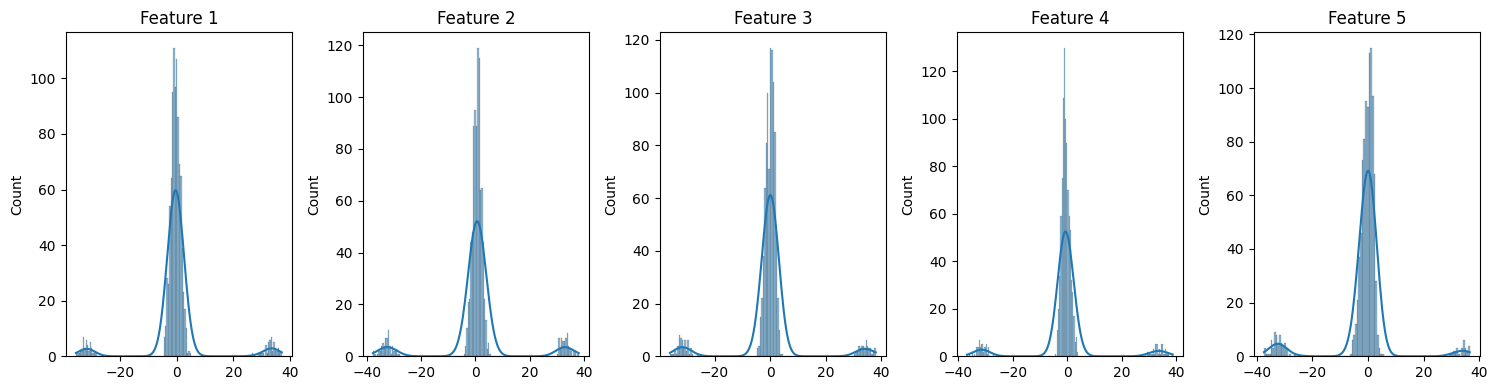

In [15]:
# Plot a time series for each category
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

axes = axes.flatten()

sns.histplot(datasets[9].to_numpy()[:, 0], kde=True, ax=axes[0])
axes[0].set_title('Feature 1')
sns.histplot(datasets[9].to_numpy()[:, 1], kde=True, ax=axes[1])
axes[1].set_title('Feature 2')
sns.histplot(datasets[9].to_numpy()[:, 2], kde=True, ax=axes[2])
axes[2].set_title('Feature 3')
sns.histplot(datasets[9].to_numpy()[:, 3], kde=True, ax=axes[3])
axes[3].set_title('Feature 4')
sns.histplot(datasets[9].to_numpy()[:, 4], kde=True, ax=axes[4])
axes[4].set_title('Feature 5')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

## Data analysis 1

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

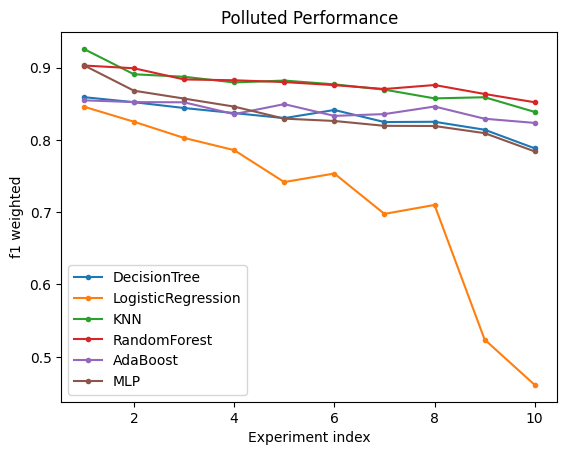

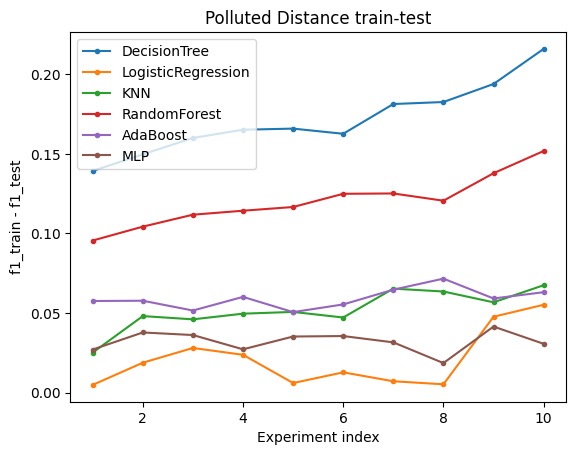

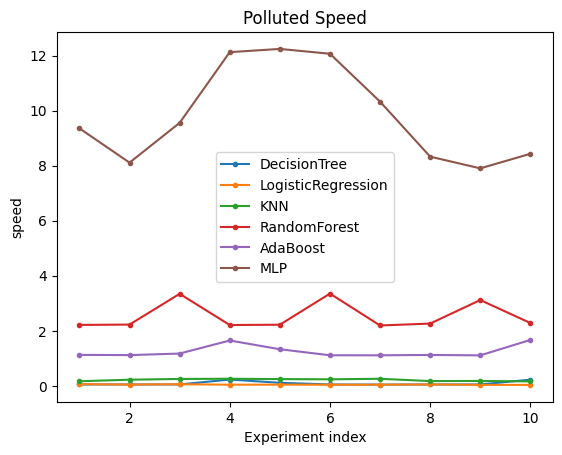

In [21]:
# CLASSIFICATION
results_for_each_algorithm = []
for algorithm in CLASSIFICATION_ALGORITHMS:

    results_single_algorithm = []

    for i in range(0, 10):
        # DATA ANALYSIS
        results_analysis = classification(datasets[i], y, algorithm, SEED)
        results_single_algorithm.append(results_analysis)

    results_for_each_algorithm.append(results_single_algorithm)

# RESULTS EVALUATION
# EXAMPLE FOR USING THE SCRIPTS TO PLOT THE RESULTS
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Polluted Performance", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Polluted Distance train-test", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Polluted Speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [22]:
for i, element in enumerate(results_for_each_algorithm):
  algo = pd.DataFrame(element)
  print('Numerical results of ', CLASSIFICATION_ALGORITHMS[i], ':')
  print(algo)
  print('-------------------------------------')

Numerical results of  DecisionTree :
   mean_perf  distance     speed
0   0.859062  0.139228  0.052172
1   0.852073  0.149659  0.051020
2   0.844045  0.159968  0.051708
3   0.837033  0.165140  0.230016
4   0.830044  0.165842  0.112076
5   0.841334  0.162594  0.051004
6   0.824614  0.181293  0.048013
7   0.825000  0.182544  0.051255
8   0.813994  0.193870  0.051893
9   0.788298  0.215917  0.224971
-------------------------------------
Numerical results of  LogisticRegression :
   mean_perf  distance     speed
0   0.845905  0.004771  0.062599
1   0.825067  0.018731  0.046949
2   0.802674  0.027986  0.060062
3   0.785809  0.023710  0.042584
4   0.741643  0.005962  0.045804
5   0.753448  0.012666  0.041837
6   0.697638  0.007081  0.041017
7   0.709980  0.005169  0.050680
8   0.523834  0.047611  0.036561
9   0.461136  0.055123  0.034859
-------------------------------------
Numerical results of  KNN :
   mean_perf  distance     speed
0   0.925746  0.025103  0.167916
1   0.890705  0.048029  

## Data preparation

### Statistic based

In [23]:
# this function computes the Z-score of the a set of elements
# Parameter:
# data: set of elements on which the z-score is computed
# threshold: value beyond which a point is considered an outlier
#
# return: indexes of all the identified outliers
def ZS(data, threshold):
    mean = np.mean(data)
    sd = np.std(data) # calculate standard deviation
    outliers_values = [] # create empty list to store outliers
    outliers_index = []
    for index, datum in enumerate(data): # detect outliers
        z = (datum - mean) / sd  # calculate z-score
        if abs(z) > threshold:  # identify outliers
            outliers_values.append(datum)  # add to the empty list
            outliers_index.append(index)

    return outliers_index

### Model based

We tried applying this type of procedures, but although we found reasonable results, we decided to discard such techniques and not rely on them due to excessive manual tuning requested.

In [24]:
KNN = NearestNeighbors(n_neighbors = 3)

In [25]:
KNN.fit(datasets[1])

NearestNeighbors(n_neighbors=3)

In [26]:
distances, indexes = KNN.kneighbors(datasets[1])

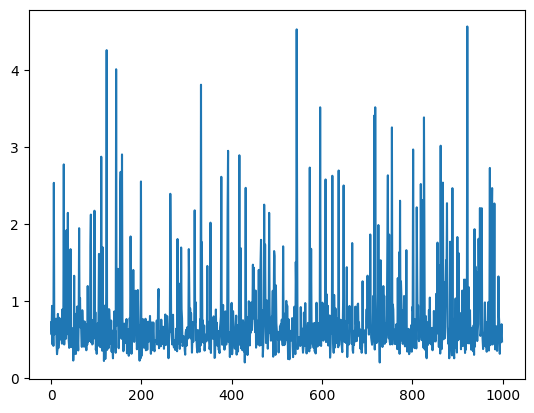

In [27]:
plt.plot(distances.mean(axis =1))

In [28]:
# the tuning parameter may change for every column of each experiment, for this reason this procedure has not been entirely considered
OUTLIER_INDEX = np.where(distances.mean(axis = 1) > 1.6)
OUTLIER_INDEX

(array([  6,  28,  31,  34,  37,  43,  62,  87,  88,  96, 106, 111, 114,
        123, 144, 153, 154, 157, 176, 199, 264, 265, 280, 288, 305, 318,
        332, 334, 353, 377, 391, 392, 417, 420, 431, 465, 472, 474, 483,
        494, 514, 544, 545, 573, 576, 596, 608, 623, 637, 648, 667, 707,
        716, 718, 725, 745, 746, 749, 755, 771, 773, 787, 802, 810, 819,
        822, 826, 827, 856, 863, 868, 877, 884, 889, 900, 903, 922, 938,
        947, 950, 954, 972, 976, 977, 982]),)

### Correction 1: **drop** the outliers row

In [29]:
# this function drop the outliers row based on the z-score value of each point
# Parameters:
# dataset: elements from which outliers are eliminated
# y: label for classification that are modified accordingly
#
# return: list of corrected training set and label set
def drop_outliers(datasets=datasets, y=y):
  corrected_list_x = []
  corrected_list_y = []

  # for ech one of the 10 experiments
  for experiment in range(10):
    drop_df = datasets[experiment].copy()
    drop_label = pd.DataFrame(y.copy())
    drop_indices = []
    num_outliers = 0

    # for each column of the dataset
    for i in range(5):
      drop_indices.extend(ZS(drop_df.to_numpy()[:, i], 2.5)) # append indices of elements to be dropped

    num_outliers = len(drop_indices)
    corrected_list_x.append(drop_df.drop(drop_indices)) # drop elements from train set
    corrected_list_y.append(drop_label.drop(drop_indices)[0].to_numpy())  # drop element from labels

    print("Experiment: ", experiment, " found ", num_outliers, "outliers")

  return corrected_list_x, corrected_list_y

In [30]:
dataset_drop_X, labels_drop_y = drop_outliers(datasets, y)

Experiment:  0  found  52 outliers
Experiment:  1  found  100 outliers
Experiment:  2  found  150 outliers
Experiment:  3  found  200 outliers
Experiment:  4  found  250 outliers
Experiment:  5  found  300 outliers
Experiment:  6  found  350 outliers
Experiment:  7  found  400 outliers
Experiment:  8  found  450 outliers
Experiment:  9  found  495 outliers


### Correction 2: substitute outliers with the **mean** of the column

In [31]:
# this function substitutes the outliers points with the value of the mean of their column
# Parameters:
# dataset: elements of the experiments from which the outliers are modified
#
# return: list of corrected training set
def mean_outliers(datasets=datasets):
  corrected_list_x = []

  # for ech one of the 10 experiments
  for experiment in range(10):
    mean_df = datasets[experiment].copy()
    mean_indices = []
    num_outliers = 0

    # for each column of the dataset
    for i in range(5):
      mean_indices.extend(ZS(mean_df.to_numpy()[:, i], 2.5)) # append indices of elements to be modified
      mean_df.iloc[mean_indices, i] = mean_df.loc[~mean_df.index.isin(mean_indices)].mean()[i] # apply correction considering only non-outlier points

    corrected_list_x.append(mean_df)
    num_outliers = len(mean_indices)
    print("Experiment: ", experiment, " found ", num_outliers, "outliers")

  return corrected_list_x

In [32]:
dataset_mean_X = mean_outliers()

Experiment:  0  found  52 outliers
Experiment:  1  found  100 outliers
Experiment:  2  found  150 outliers
Experiment:  3  found  200 outliers
Experiment:  4  found  250 outliers
Experiment:  5  found  300 outliers
Experiment:  6  found  350 outliers
Experiment:  7  found  400 outliers
Experiment:  8  found  450 outliers
Experiment:  9  found  495 outliers


## Data Analysis and Evaluation 2

### Classification with dropped elements

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

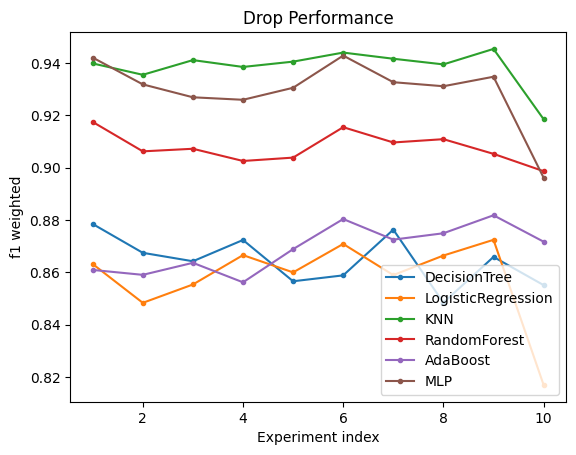

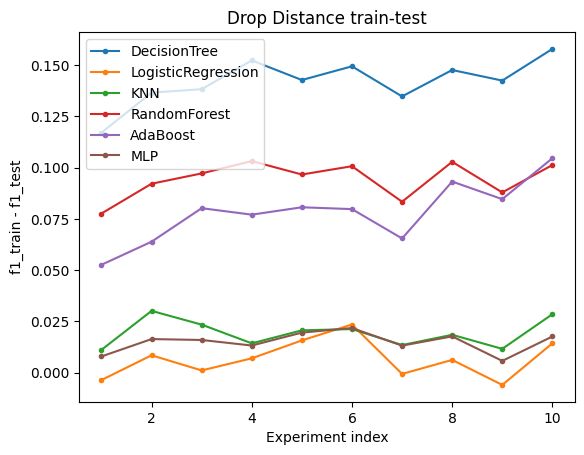

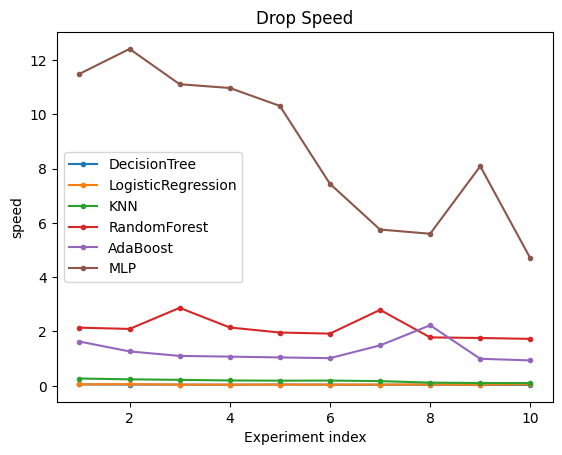

In [35]:
# CLASSIFICATION
results_for_each_algorithm = []
for algorithm in CLASSIFICATION_ALGORITHMS:

    results_single_algorithm = []

    for i in range(0, 10):
        # DATA ANALYSIS
        results_analysis = classification(dataset_drop_X[i], labels_drop_y[i], algorithm, SEED)
        results_single_algorithm.append(results_analysis)

    results_for_each_algorithm.append(results_single_algorithm)

# RESULTS EVALUATION
#EXAMPLE FOR USING THE SCRIPTS TO PLOT THE RESULTS
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Drop Performance", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Drop Distance train-test", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Drop Speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [36]:
for i, element in enumerate(results_for_each_algorithm):
  algo = pd.DataFrame(element)
  print('Numerical results of ', CLASSIFICATION_ALGORITHMS[i], ':')
  print(algo)
  print('-------------------------------------')

Numerical results of  DecisionTree :
   mean_perf  distance     speed
0   0.878502  0.117069  0.051272
1   0.867483  0.136576  0.046624
2   0.864257  0.138273  0.043646
3   0.872386  0.152312  0.040882
4   0.856607  0.142742  0.046553
5   0.858865  0.149424  0.042612
6   0.876342  0.134741  0.038553
7   0.848422  0.147627  0.042503
8   0.865916  0.142460  0.033096
9   0.855136  0.157910  0.032467
-------------------------------------
Numerical results of  LogisticRegression :
   mean_perf  distance     speed
0   0.863188 -0.003614  0.052773
1   0.848363  0.008467  0.060630
2   0.855375  0.001078  0.043802
3   0.866602  0.006984  0.043721
4   0.860000  0.015725  0.046734
5   0.870875  0.023475  0.043344
6   0.858974 -0.000628  0.046669
7   0.866443  0.006214  0.047396
8   0.872452 -0.005990  0.042363
9   0.816984  0.014307  0.057296
-------------------------------------
Numerical results of  KNN :
   mean_perf  distance     speed
0   0.939878  0.011127  0.268275
1   0.935531  0.030133  

### Classification with corrected elements (mean)

Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for DecisionTree...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for LogisticRegression...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for KNN...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for RandomForest...
Training for Ra

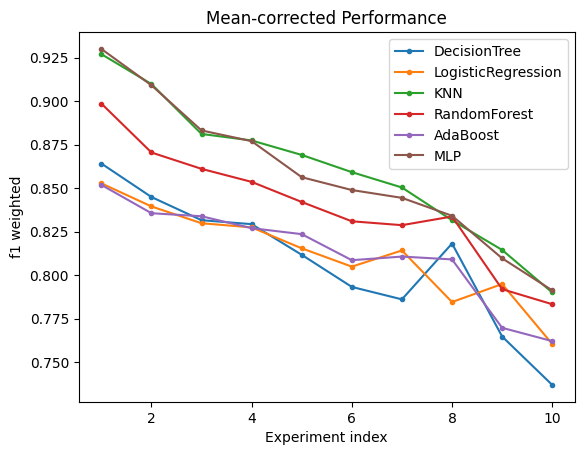

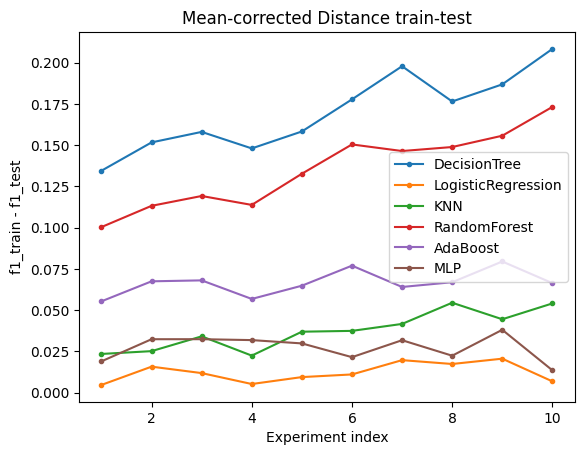

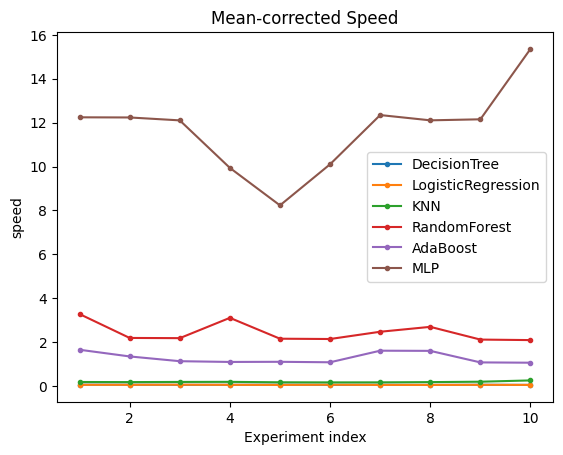

In [37]:
# CLASSIFICATION
results_for_each_algorithm = []
for algorithm in CLASSIFICATION_ALGORITHMS:

    results_single_algorithm = []

    for i in range(0, 10):
        # DATA ANALYSIS
        results_analysis = classification(dataset_mean_X[i], y, algorithm, SEED)
        results_single_algorithm.append(results_analysis)

    results_for_each_algorithm.append(results_single_algorithm)

# RESULTS EVALUATION
#EXAMPLE FOR USING THE SCRIPTS TO PLOT THE RESULTS
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Mean-corrected Performance", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Mean-corrected Distance train-test", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[1,2,3,4,5,6,7,8,9,10], x_label="Experiment index", results=results_for_each_algorithm, title="Mean-corrected Speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [38]:
for i, element in enumerate(results_for_each_algorithm):
  algo = pd.DataFrame(element)
  print('Numerical results of ', CLASSIFICATION_ALGORITHMS[i], ':')
  print(algo)
  print('-------------------------------------')

Numerical results of  DecisionTree :
   mean_perf  distance     speed
0   0.864170  0.134498  0.055218
1   0.844923  0.151658  0.053959
2   0.831607  0.158022  0.048544
3   0.829328  0.148014  0.049160
4   0.811726  0.158280  0.054477
5   0.793276  0.177740  0.047512
6   0.786130  0.197821  0.050727
7   0.818205  0.176456  0.043858
8   0.764789  0.186832  0.051798
9   0.736982  0.208309  0.045323
-------------------------------------
Numerical results of  LogisticRegression :
   mean_perf  distance     speed
0   0.852774  0.004681  0.047982
1   0.839512  0.015750  0.048791
2   0.829858  0.011850  0.052884
3   0.827481  0.005232  0.047554
4   0.815449  0.009427  0.043998
5   0.804935  0.011033  0.052063
6   0.814212  0.019693  0.043736
7   0.784594  0.017367  0.044024
8   0.794926  0.020585  0.046909
9   0.760474  0.006837  0.043626
-------------------------------------
Numerical results of  KNN :
   mean_perf  distance     speed
0   0.927007  0.023454  0.177157
1   0.909815  0.025153  